# Retrieving JWST Exoplanet Spectra
Part 1 of the [Primer on Exoplanets and JWST](https://github.com/Kappibw/JWST) series.

## Who is this tutorial for?

People that
- Have some programming know-how (basic python is fine!)
- *Don't* necessarily have an education/ experience in astronomy/astrophysics
- Are excited about JWST's potential to tell us about planets outside our solar system!

## What does this tutorial cover?

A primer on retrieving and displaying exoplanet spectra, including:
- A guide to downloading raw JWST spectra data via astroquery
- Pointers to data processing software for raw JWST data
- Fetching and displaying WASP-39B's _processed_ spectrum, the first exoplanet [JWST confirmed has CO2 in its atmosphere](https://www.nasa.gov/feature/goddard/2022/nasa-s-webb-detects-carbon-dioxide-in-exoplanet-atmosphere).

## What should you know going in?

- [The 6](https://webbtelescope.org/resource-gallery/articles) (quick) articles on spectroscopy 101

# 1. Introduction

If you did my [image retrieval tutorial](https://github.com/Kappibw/JWST/blob/main/1_accessing_jwst_data.ipynb) then you, like me, might have been bouyed by how straightforward it was to start playing with visual images of astronomical objects taken by JWST. However, the reason I am particularly excited by JWST is because of its ability to tell us about the environments of planets beyond our solar system. Because planets are tiny compared to their stars, and orbit close to them, they are very difficult to take pictures of directly, and when we do they just [look like small blobs](https://blogs.nasa.gov/webb/2022/09/01/nasas-webb-takes-its-first-ever-direct-image-of-distant-world/). 

However, we have another tool up our sleeve- _spectroscopy_. JWST is able to split the light coming from exoplanets into the different wavelengths that make it up so that we can see how much of each wavelength of light the planet's atmosphere is absorbing. As you will have learned in the [spectroscopy 101 articles](https://webbtelescope.org/resource-gallery/articles), this can then tell us what molecules are present on that alien world. Spectra might not look very inspiring at first glance, but they contain rich data, and are a fundamental part of exoplanet research.

#### Information Extraction

The catch here is that JWST doesn't directly record spectra. For images, light from the object falls on the JWST detectors and we see the direct result- brighter pixels have more light. However, for spectra light is split inside JWST and the spread out light lands on a detector. This smear of light then has to be processed to tease out what it is telling us- namely how much light was received from each wavelength.

But that's not all that makes it difficult. When we point JWST at exoplanets, we are actually pointing it at the exoplanet's host star, which is much bigger. For transit spectroscopy (the focus of these tutorials), it is really the host star's light that JWST records while the planet travels in between JWST and the star, and then intepret how much that light dims as the planet passes in front. That means that not only do we have to interpret the "smear" of light, but we have to figure out how to measure the tiny variance in the starlight during transit. 

You can see in the image below that the starlight only dips by about 1% when the planet is in front of it, and that is for a massive gas giant (imagine trying to tease apart the light blocked by a tiny earth-like planet!). 

<img src="https://drive.google.com/uc?id=1h4DsDWSjCErhbw3PchLE30G28ox2o2SJ"></img> 

When we see the final spectrum, we are looking at a measure of the "Amount of Light Blocked" of the star, or $\frac{\Delta F}{F}$, where F is Flux (light). This is equal to the ratio of the size of the planet versus the size of its host star, a quantity you'll often see as $\frac{R_p^2}{R_s^2}$, which is the radius of the planet squared over the radius of the star squared. So we get a handy way to compute the radius of an exoplanet by measuring the light it blocks. [This article](https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/) explains the maths involved quite well. So when we look at spectra, we are equivalently looking at the amount of blocked light, or the planet size.

This all means that you have to isolate just the tiny effects of a passing planet on the starlight and then figure out how much that effect changes by wavelength- because for wavelengths that the planet's atmosphere is absorbing, we will get just a _little tiny_ bit less light than we do for wavelengths that pass through the atmosphere unencumbered, which will make the planet look just _a tiny bit_ bigger at those wavelengths. And it's that information that tells us whether there's water, CO2, etc in the atmosphere.

<img src="https://drive.google.com/uc?id=1imL0MnItR5wPQkfJIijsYtXK0077bOVE"></img>

A daunting task! Luckily there is a software package called `Eureka!` that can perform all this intepretation, starlight subtraction and general processing, but in this tutorial we are going to do some cheating. 

We will look at how to get raw planetary spectroscopy data from JWST, and take a look at how we _could_ crunch down all that raw data using `Eureka!` into a spectrum like those [we are used to seeing](https://www.nasa.gov/image-feature/goddard/2022/nasa-s-webb-reveals-steamy-atmosphere-of-distant-planet-in-detail) - a measure of flux per wavelength. Then we are going to skip actually doing that processing, because lucky for us, the team that wrote the paper announcing [the discovery of CO2 on WASP-39B](https://www.nasa.gov/feature/goddard/2022/nasa-s-webb-detects-carbon-dioxide-in-exoplanet-atmosphere) had to process the data too, using the same method, and they published their processed data for all to download!

#### Why aren't we doing the full processing pipeline?

I had a go at running the `Eureka!` pipeline to do the processing myself but:
  1) As promised by the premise of these tutorials, I am not an expert
  2) The software itself is under active development, and doesn't have beginner-friendly debugging tips
  3) The amount of data I had to crunch is massive (>8GB) and I don't want to make that a requirement of this tutorial.
  
I did manage to run the pipeline start to finish, but my output didn't look as expected, and my limited knowledge of the field meant I didn't have much luck messing around with configuration options to fix it. If you decide to try the processing and have better luck than me, let me know, I'd love to add to this tutorial. For now I'm just including the steps you could take to run the pipeline if you wish!


# 2. Set Up


## Eureka!

Note that you can skip installing `Eureka!` if you don't want to try your own processing, and can instead just read through the steps. It will save you cloning a github repository.

### Conda Environment
Eureka! strongly reccomends installing it in a fresh conda environment. Assuming you [use conda](https://docs.conda.io/en/latest/miniconda.html) (encouraged), you'll then also have to install the other packages you need for this tutorial into your new conda environment as well, even if you already have them (like Jupyter-lab).

### Install Eureka
From the instructions [here](https://eurekadocs.readthedocs.io/en/latest/installation.html#installation).

### Locate the configuration files
If you cloned the Eureka! github during the install above, you should be able to follow the path `Eureka/demos/JWST` inside the cloned repo to find the demo files. If you didn't clone the repo then you can find them on the [github page for the project](https://github.com/kevin218/Eureka/tree/main/demos/JWST). Only a few of these are going to be relevant to us, so make sure you can find the following files.
 1. [S4_template.ecf](https://github.com/kevin218/Eureka/blob/main/demos/JWST/S4_template.ecf)
 2. [S5_fit_par_template.epf](https://github.com/kevin218/Eureka/blob/main/demos/JWST/S5_fit_par_template.epf)
 3. [S5_template.ecf](https://github.com/kevin218/Eureka/blob/main/demos/JWST/S5_template.ecf)
 4. [S6_template.ecf](https://github.com/kevin218/Eureka/blob/main/demos/JWST/S6_template.ecf)


## Jupyter
In order to follow along with this tutorial in place, you will need to be able to run Jupyter notebooks (install from [here](https://jupyter.org/install)). Then you can download this notebook from git and open it in Jupyter.

In [1]:
#run this cell in place once you have Juypyter up and running.
print("hello JWST!")

hello JWST!


## Astroquery
Now, you'll need python packages that are specifically used by astronomers. We will use the library astroquery, which is affiliated with the astropy project, and makes programatically accessing archives of astronomical data straightforward.

__Note:__ I sometimes get timeout errors using astroquery, and re-running seems to clear them.

1. Install astropy from the instructions [here](https://docs.astropy.org/en/stable/install.html).
2. Install the astroquery library from the instructions [here](https://astroquery.readthedocs.io/en/latest/#installation).

In [2]:
# Check we can load astroquery packages, that we will use later.
from astropy.io import fits
from astroquery.mast import Observations
print("done")

done


## JWST Data

Lastly, we will need to set up access for the raw JWST data. JWST data is made available via the Mikulski Archive for Space Telescopes (MAST). This is a huge archive of astronomical data from lots of different missions including Hubble, TESS and Kepler, and is named for [Barabara Mikulski](https://en.wikipedia.org/wiki/Barbara_Mikulski), as US senator who was a big supporter of Hubble and Webb. 

There are several ways to access the data it stores: via the online portal, the API, bulk AWS download scripts, or you can look up what information we have for a chosen exoplanet in their exoplanet-specific UI exo.MAST. For example, [here is the exo.MAST page for WASP-96b](https://exo.mast.stsci.edu/exomast_planet.html?planet=WASP96b), the exoplanet observed in JWST's [first images](https://www.nasa.gov/webbfirstimages).

For this tutorial, we will use the python library Astroquery, which is affiliated with the astropy project.

1. Sign up for a MAST portal account (Managed by the Space Telescope Science Institude and called "My Space Telescope" - MyST) [here](https://proper.stsci.edu/proper/authentication/auth).

In [3]:
from astroquery.mast import Observations
print("done")

done


# 3. Downloading raw JWST data

Now we have all our tools, let's look at some real data! We are going to focus on [exoplanet transit](https://exoplanets.nasa.gov/faq/31/whats-a-transit) data. There are [other methods](https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/) of examining exoplanets, but we won't dive into those here.

We are going to look up data for WASP-39B, a gas giant 700 light years away that was the first planet with [confirmed CO2 in its atmosphere](https://www.nasa.gov/feature/goddard/2022/nasa-s-webb-detects-carbon-dioxide-in-exoplanet-atmosphere), thanks to JWST. If we look at the [exo.MAST page for WASP-39B](https://exo.mast.stsci.edu/exomast_planet.html?planet=WASP39B) we can see in the panel on the right that JWST observed WASP-39B during a transit, which is what we are after! 

Seeing as this is a programming-centric tutorial, let's get some more information programmatically via astroquery (which queries the same MAST data sources as exo.MAST).

In [6]:
# Limit our query to WASP-39_b
obsByName = Observations.query_object("WASP-39_b",radius=".02 deg")
print("Number of results:",len(obsByName))
print(obsByName.keys())

# See if you can see any observations by JWST!
jwst_only = obsByName[(obsByName['obs_collection'] == 'JWST')]
print(len(jwst_only))
print(jwst_only['obsid','obs_id','instrument_name'])

Number of results: 1446
['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURL', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'distance']
22
 obsid                           obs_id                         instrument_name
-------- ------------------------------------------------------ ---------------
87742481     jw01366-o001_t001_niriss_clear-gr700xd-substrip256          NIRISS
87742384     jw01366-o001_t001_niriss_f277w-gr700xd-substrip256          NIRISS
87682152     jw01366-o002_t001_nircam_f322w2-grismr-subgrism256          NIRCAM
87769481 jw01366-o003_t001_nirspec_f290lp-g395h-s1600a1-sub2048         NIRSPEC
87625349   jw01366-o004_t001_nirspec_clea

Both NIRISS and NIRSPEC collect spectrocopy data, but at the time of writing processing NIRISS data is tricky and not yet fully supported in `Eureka!`. So we are just going to narrow down our options to NIRSPEC only:

In [29]:
jwst_only = jwst_only[(jwst_only['instrument_name'] == 'NIRSPEC')]
print(jwst_only['obsid','obs_id','t_min','t_exptime', 'calib_level', 'dataproduct_type'])

# Note that t_min is in MJD - Modified Julian Day, a unit used in astronomy.
from astropy.time import Time
start_times = Time(jwst_only['t_min'], format='mjd')
print('Human Readable t_min:')
print([x.isot for x in start_times])

 obsid                           obs_id                               t_min       t_exptime calib_level dataproduct_type
-------- ------------------------------------------------------ ----------------- --------- ----------- ----------------
87769481 jw01366-o003_t001_nirspec_f290lp-g395h-s1600a1-sub2048 59790.90101464306 29789.053           3         spectrum
87625349   jw01366-o004_t001_nirspec_clear-prism-s1600a1-sub512 59770.62185407593  29614.96           3         spectrum
87618706                  jw01366004001_04101_00001-seg001_nrs2 59770.64645755787  29614.96           2            image
87618659                  jw01366004001_04101_00001-seg002_nrs2 59770.64645755787  29614.96           2            image
87618657                  jw01366004001_04101_00001-seg003_nrs2 59770.64645755787  29614.96           2            image
87618709                  jw01366004001_04101_00001-seg004_nrs2 59770.64645755787  29614.96           2            image
Human Readable t_min:
['2022-07-

### Interpreting MAST entries
If we go to the MAST portal we can do the same filtering and see [these results in a UI](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CAOMDB%22%2C%22inputText%22%3A%22wasp-39b%22%2C%22paramsService%22%3A%22Mast.Caom.Cone%22%2C%22title%22%3A%22MAST%3A%20wasp-39b%22%2C%22columns%22%3A%22*%22%2C%22caomVersion%22%3Anull%7D).

You can see that thre are 6 results. There are many columns of metadata, including things like the `s_ra` Right Ascension (RA) and `s_dec` Declination (DEC) values for WASP-39B, which is the coordinates of the observation- where to look in the sky to find the planet. Let's take a closer look at the metadata columns I pulled out above - `dataproduct_type`, `obs_id`, `t_min`, `t_exptime` and `calib_level`.

First off, we are interested in spectrums, not images, so let's just look at those.

In [30]:
jwst_only = jwst_only[(jwst_only['dataproduct_type'] == 'spectrum')]
print(jwst_only['obsid','obs_id','t_min','t_exptime', 'calib_level', 'dataproduct_type'])

 obsid                           obs_id                               t_min       t_exptime calib_level dataproduct_type
-------- ------------------------------------------------------ ----------------- --------- ----------- ----------------
87769481 jw01366-o003_t001_nirspec_f290lp-g395h-s1600a1-sub2048 59790.90101464306 29789.053           3         spectrum
87625349   jw01366-o004_t001_nirspec_clear-prism-s1600a1-sub512 59770.62185407593  29614.96           3         spectrum


#### Calibration Level
`calib_level` denotes how "raw" the data is. STScI has its own [calibration pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview), so you can get data from them totally raw (stage 0) or in a more refined state, it's worth poking around at the different types of data they output and what stages they are [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/product_types.ht), but in short the most raw data is the numbers directly output by the instruments, and the early stages calibrate the data and remove systematics. 

The two observations we kept have `calib_level` 3. One is from July 10th and one from July 30th, and they used the NIRSPEC instrument with different filters (hence the difference in their observation id names). Let's choose the earlier one - `jw01366-o004_t001_nirspec_clear-prism-s1600a1-sub512`:


In [31]:
jwst_only = jwst_only[(jwst_only['obs_id'] == 'jw01366-o004_t001_nirspec_clear-prism-s1600a1-sub512')]
print(jwst_only['obsid','obs_id','t_min','t_exptime', 'calib_level', 'dataproduct_type'])

 obsid                          obs_id                              t_min       t_exptime calib_level dataproduct_type
-------- ---------------------------------------------------- ----------------- --------- ----------- ----------------
87625349 jw01366-o004_t001_nirspec_clear-prism-s1600a1-sub512 59770.62185407593  29614.96           3         spectrum


Unfortunately STScI doesn't process all the way through to exoplanet spectra, they [stop at `calib_level` 3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/product_types.ht) data, which is still at the point of measuring the _host_ starlight over time.

`Eureka!` also has stages of processing, and its first 3 mirror the first 3 stages of STScI's calibration pipeline. So theoretically you could take stage 0 NIRSPEC data and run it fully through `Eureka!`, or you could take stage 1 data and run it through steps 2 onward in `Eureka!`, and so on. At the moment, the highest level NIRSPEC data you can start off with in `Erueka!` is level 2, which you then feed into `Eureka!` level 3.

That's annoying, as we can only see level 3 data here. Not to worry, STScI makes all levels of data available for the observations, but they are packaged as `data products` nested deeper in the database. Let's see what data products are available for our observation.

In [33]:
# Filter down to just the observation we are interested in.
obs_87625349 = jwst_only[(jwst_only['obsid'] == '87625349')]

print("\n NIRSpec Observation of WASP-39 B: \n")
print(obs_87625349)

# Get a list of the "Data Products" available from the observations.
data_products = Observations.get_product_list(obs_87625349)
print("\n Data Products: \n")
print(data_products)


 NIRSpec Observation of WASP-39 B: 

intentType obs_collection provenance_name instrument_name project filters ... dataRights mtFlag srcDen  obsid   distance
---------- -------------- --------------- --------------- ------- ------- ... ---------- ------ ------ -------- --------
   science           JWST         CALJWST         NIRSPEC    JWST   CLEAR ...     PUBLIC  False    nan 87625349      0.0

 Data Products: 

 obsID   obs_collection dataproduct_type ... parent_obsid dataRights calib_level
-------- -------------- ---------------- ... ------------ ---------- -----------
87625349           JWST         spectrum ...     87625349     PUBLIC           3
87625349           JWST         spectrum ...     87625349     PUBLIC           3
87625349           JWST         spectrum ...     87625349     PUBLIC           3
87625349           JWST         spectrum ...     87625349     PUBLIC           3
87618704           JWST            image ...     87625349     PUBLIC           1
87618704     

Yikes! As you can see there are lots of data products- some spectra, some images.

We know we want spectra, and we also know we want `calib_level` 2 to feed to Eureka. Let's also filter down to 'SCIENCE' `productType`, because those have been "certified" as good to go for science uses (i.e. they have been calibrated and validated).

In [40]:
obs_87625349_products = data_products[((data_products['dataproduct_type'] == 'spectrum')) &
                      (data_products['calib_level'] == 2) & 
                      (data_products['productType'] == 'SCIENCE')]
obs_87625349_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str4,str8,str52,str64,str1,str83,str9,str28,str13,str1,str7,str5,str4,str65,int64,str8,str6,int64
87618689,JWST,spectrum,jw01366004001_04101_00001-seg001_nrs1,exposure (L2c): 3D Calibrated data per integration,S,mast:JWST/product/jw01366004001_04101_00001-seg001_nrs1_o004_crfints.fits,SCIENCE,--,ANNNN_CRFINTS,--,CALJWST,1.5.3,1366,jw01366004001_04101_00001-seg001_nrs1_o004_crfints.fits,1623824640,87625349,PUBLIC,2
87618689,JWST,spectrum,jw01366004001_04101_00001-seg001_nrs1,exposure (L2b): 3D calibrated exposure,S,mast:JWST/product/jw01366004001_04101_00001-seg001_nrs1_calints.fits,SCIENCE,--,CALINTS,--,CALJWST,1.5.3,1366,jw01366004001_04101_00001-seg001_nrs1_calints.fits,1623824640,87625349,PUBLIC,2
87618689,JWST,spectrum,jw01366004001_04101_00001-seg001_nrs1,exposure (L2a): 2D count rate averaged over integrations,S,mast:JWST/product/jw01366004001_04101_00001-seg001_nrs1_rate.fits,SCIENCE,--,RATE,--,CALJWST,1.5.3,1366,jw01366004001_04101_00001-seg001_nrs1_rate.fits,380160,87625349,PUBLIC,2
87618689,JWST,spectrum,jw01366004001_04101_00001-seg001_nrs1,exposure (L2a): 3D countrate per integration,S,mast:JWST/product/jw01366004001_04101_00001-seg001_nrs1_rateints.fits,SCIENCE,--,RATEINTS,--,CALJWST,1.5.3,1366,jw01366004001_04101_00001-seg001_nrs1_rateints.fits,1999221120,87625349,PUBLIC,2
87618689,JWST,spectrum,jw01366004001_04101_00001-seg001_nrs1,exposure/target (L2b/L3): 1D extracted spectrum per integration,S,mast:JWST/product/jw01366004001_04101_00001-seg001_nrs1_x1dints.fits,SCIENCE,--,X1DINTS,--,CALJWST,1.5.3,1366,jw01366004001_04101_00001-seg001_nrs1_x1dints.fits,484591680,87625349,PUBLIC,2
87618646,JWST,spectrum,jw01366004001_04101_00001-seg002_nrs1,exposure (L2c): 3D Calibrated data per integration,S,mast:JWST/product/jw01366004001_04101_00001-seg002_nrs1_o004_crfints.fits,SCIENCE,--,ANNNN_CRFINTS,--,CALJWST,1.5.3,1366,jw01366004001_04101_00001-seg002_nrs1_o004_crfints.fits,1623824640,87625349,PUBLIC,2
87618646,JWST,spectrum,jw01366004001_04101_00001-seg002_nrs1,exposure (L2b): 3D calibrated exposure,S,mast:JWST/product/jw01366004001_04101_00001-seg002_nrs1_calints.fits,SCIENCE,--,CALINTS,--,CALJWST,1.5.3,1366,jw01366004001_04101_00001-seg002_nrs1_calints.fits,1623824640,87625349,PUBLIC,2
87618646,JWST,spectrum,jw01366004001_04101_00001-seg002_nrs1,exposure (L2a): 2D count rate averaged over integrations,S,mast:JWST/product/jw01366004001_04101_00001-seg002_nrs1_rate.fits,SCIENCE,--,RATE,--,CALJWST,1.5.3,1366,jw01366004001_04101_00001-seg002_nrs1_rate.fits,380160,87625349,PUBLIC,2
87618646,JWST,spectrum,jw01366004001_04101_00001-seg002_nrs1,exposure (L2a): 3D countrate per integration,S,mast:JWST/product/jw01366004001_04101_00001-seg002_nrs1_rateints.fits,SCIENCE,--,RATEINTS,--,CALJWST,1.5.3,1366,jw01366004001_04101_00001-seg002_nrs1_rateints.fits,1999221120,87625349,PUBLIC,2


Ok, this is still a lot of data, but now it's managable. We can see here that we only have 4 different `obs_id`, with the only difference being seg001 -> seg004.

This is because there is a _tonne_ of data here, and it is broken into "segments" so you can download it in managable (but still 2 Gigabyte!) chunks. The segments are chronological, so the first segment will be some data where the planet isn't in front of the star yet, etc.

Within the same `obs_id` you can see they are differentiated by `dataURI`. These are different types of files - you can see `rateints`, `rate`, `x1dints`, `calints` and `cfrints`. They are all `.fits` files, which is a common filetype in astronomy. The different types are different data product types, like you would have seen in the [docs earlier](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/product_types.ht) and can read more about if you like. 

`Eureka!` uses these files as input to its 3rd stage.

#### STOP!!!
Here's where you can download this data (I've put the code - commented out - below). This is, and I cannot stress this enough, a _lot_ of data. Only do this if you actively want to try your hand at running this `Eureka!` pipeline yourself.

In [41]:
# ONLY UNCOMMENT AND RUN THIS IF YOU WANT TO DOWNLOAD ALL THE RAW DATA!
# manifest = Observations.download_products(obs_87625349_products)
# manifest

# 4. Eureka!

If you downloaded the raw data, you now almost have level 2 JWST data ready to pipe into stage 3 of `Eureka!`. I'll give you some pointers and example code on how to do that, but if you aren't doing your own processing of the raw data, this code won't do anything/work.

Note that if you want the full transit, you'll have to combine the data from the 4 segments. You can do this with a python script. You can also run the pipeline with just one segment to check it is all working before you concatenate all the data together.

I've cleared the output from the cells below because there's a lot of it.

#### Quickstart

Lucky for you, `Eureka!`'s [quickstart guide](https://eurekadocs.readthedocs.io/en/latest/quickstart.html) uses WASP-39B as an example! This is great, because it means that the configuration files `Eureka!` uses to set parameters are all supposedly already tuned to WASP-39B.

You can follow the quickstart directly, but note the following:

  - In Step 2 (Download the Data), you've already done that, you'll just need to link Eureka to your download directory when they tell you to set the `inputdir` in your S3_wasp39b.ecf file.
  - Their quickstart starts with Stage 2 eureka, using Stage 1 JWST output. You're using Stage 2 output, so you can skip all the Stage 2 stuff they do (like configuring the S2_\*.ecf file)
  
Once you've configured your .ecf and .epf files, you can use the code below to run Eureka stages 3 - 6. Note that it will save output in your working directory as well as displaying it in here.

In [43]:
# Eureka Imports and Set Up
import sys
import os
import eureka.lib.plots
import time as time_pkg
from eureka.lib import readECF
from eureka.lib import util
import eureka.S3_data_reduction.s3_reduce as s3
import eureka.S4_generate_lightcurves.s4_genLC as s4
import eureka.S5_lightcurve_fitting.s5_fit as s5
import eureka.S6_planet_spectra.s6_spectra as s6

# Set eventlabel to the common string we added to all the filenames.
eventlabel = 'wasp39b'

# Tell eureka to look in the current working directory for the ecf files.
import os
ecf_path = '.'+os.sep

# Set up some parameters to make plots look nicer.
# You can set usetex=True if you have LaTeX installed
eureka.lib.plots.set_rc(style='eureka', usetex=False, filetype='.png')

# Make sure you have the correct Eureka variable set.
if "CRDS_PATH" in os.environ:
    print("Found: ", os.getenv("CRDS_PATH"))

Found:  /Users/kappi/crds_cache


#### Stage 3
"Using Stage 2 outputs, performs background subtraction and optimal spectral extraction. For spectroscopic observations, this stage generates a time series of 1D spectra. For photometric observations, this stage generates a single light curve of flux versus time."

In [ ]:
s3_spec, s3_meta = s3.reduce(eventlabel, ecf_path=ecf_path)

#### Stage 4
"Using Stage 3 outputs, generates spectroscopic light curves by binning the time series of 1D spectra along the wavelength axis. Optionally removes drift/jitter along the dispersion direction and/or sigma clips outliers."

In [ ]:
s4_spec, s4_lc, s4_meta = s4.genlc(eventlabel, ecf_path=ecf_path)

#### Stage 5
Fits the light curves with noise and astrophysical models using different optimization or sampling algorithms.

In [ ]:
s5_meta = s5.fitlc(eventlabel, ecf_path=ecf_path)

#### Stage 6
"Displays the planet spectrum in figure and table form using results from the Stage 5 fits."

In [ ]:
s6_meta = s6.plot_spectra(eventlabel, ecf_path=ecf_path)

I hope this was helpful and you managed to process your raw data all the way through to an exoplanet spectrum! For the rest of us, let's cheat a bit and download the processed spectra data used in the [CO2 paper](https://arxiv.org/pdf/2208.11692.pdf) from zenodo :)

# 5. Grabbing Processed Spectra from Zenodo

Here's where we let the experts do the data processing, and download and display their finished spectra, which we will use in the next tutorial to match our exoplanet models to.

At the top of page 19 in [the paper that confirmed CO2 on WASP-39B](https://arxiv.org/pdf/2208.11692.pdf) they say "All the data and models presented in this publication can be found at
[https://doi.10.5281/zenodo.6959427](https://doi.10.5281/zenodo.6959427)". That link doesn't work, but this one does: https://zenodo.org/record/6959427#.YxvFNuzMJqu.

You should see `EUREKA_REDUCTION.txt` as one of the files listed. Download the .zip and have a look for it at the path `ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt`.

In [56]:
from astropy.io import ascii
# This will work if you are using conda and put the downloaded folder in your current env top folder. Feel
# free to change this if you used a different system.
eureka_reduction_path = os.getenv("CONDA_PREFIX") + '/ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt'
data = ascii.read(eureka_reduction_path)

In [58]:
data.colnames

['wavelength',
 'bin_width',
 'tr_depth',
 'tr_depth_errneg',
 'tr_depth_errpos',
 'ecl_depth',
 'ecl_depth_errneg',
 'ecl_depth_errpos']

Cool! `tr_depth` is "transit depth" which is how much light was blocked. Let's plot it.

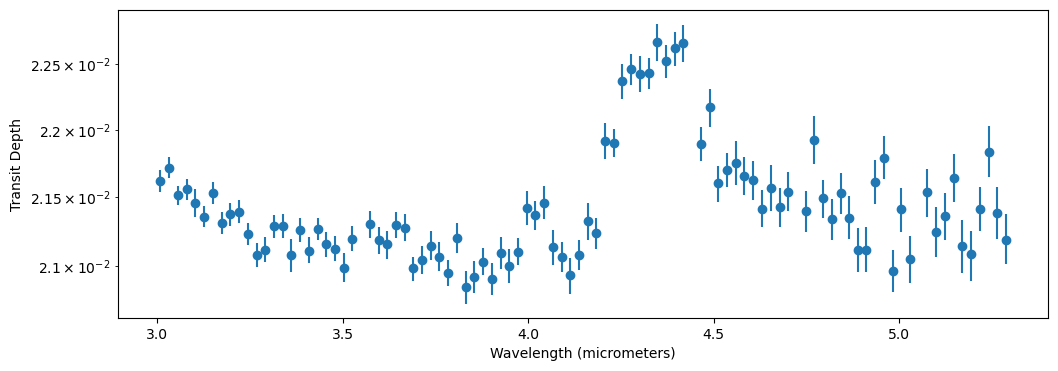

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.errorbar(data['wavelength'], data['tr_depth'], [data['tr_depth_errneg'], data['tr_depth_errpos']],fmt='o')
plt.yscale('log')
plt.ylabel('Transit Depth')
plt.xlabel('Wavelength (micrometers)')
plt.show()

Yay! There's our spectrum, with the telltale CO2 spike between 4.0 and 4.5 microns. In the next tutorial we will use this and try to get a model to fit it. Let's see what NASA published, to sanity check what we have:

<img src="https://drive.google.com/uc?id=1ekTkENEFgAJV5PyTw2_AQKPm-fCJizGq"></img>